In [1]:
import sys
sys.path.append("..")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from env import SimpleModel, GeneralSimpleModel
from wrappers import ImpactWrapper
import gym
import glob, os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
from env import SimpleModel, GeneralSimpleModel
from wrappers import ImpactWrapper
from agents import AgentCE
from train import cem
from utils import mse, mspe
import torch
import pickle
import pylab

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
%matplotlib inline

# Model Based RL Simple model

In [3]:
# true system params
big_b=1
big_omega=1
theta=0
m=1
k=0.1
beta=0.02
big_f_0=1
t_min=0
t_max=10

t0 = 0
t_step = 1
n_steps = 8
n_prev = 3

delta = beta / (2 * m)
omega_0 = k / m

impact_amplitude = 1
damping_ratio = 0.05


metric="mse"

In [4]:
def x_impact(t, a=impact_amplitude, b=damping_ratio):
#     if t < 0:
#         return 1
    return a * np.exp(-t * b)

def x_pendulum(t, big_b, big_omega, theta):
    return big_b * np.cos(big_omega * t - theta)

def generate_history(t0, step, n_steps, big_b=big_b, big_omega=big_omega, theta=theta,
                     impact=x_impact, x_pendulum=x_pendulum):
    res = []
    for _ in range(n_steps):
        res.append(
            x_pendulum(t0, big_b, big_omega, theta) * impact(t0)
        )
        t0 += step
    return res

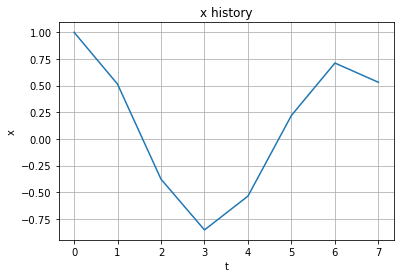

In [5]:
history = generate_history(t0, t_step, n_steps)

plt.title("x history")
plt.xlabel("t")
plt.ylabel("x")
plt.grid(True)
plt.plot(history)
plt.show()

In [6]:
history = generate_history(t0=t0, step=t_step, n_steps=n_steps, impact=lambda t: 1)
env = SimpleModel(history=history, t0=t0, t_step=t_step, n_steps=n_steps, big_f_0=big_f_0, k=k, n_prev=n_prev)

In [7]:
env.action_space = gym.spaces.Box(
    np.array([m, delta, big_omega]) - 0.0001,
    np.array([m, delta, big_omega]) + 0.0001,
    dtype=np.float32
)

In [8]:
assert np.all(env.action_space.high == np.array([m, delta, big_omega], np.float32) + 0.0001)
env.reset()
assert np.all(env.action_space.high == np.array([m, delta, big_omega], np.float32) + 0.0001)

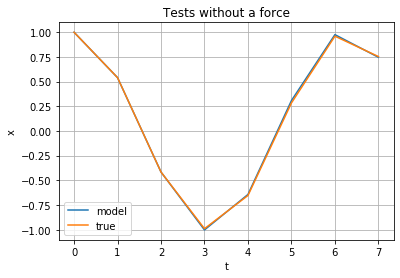

In [9]:
points = list(env.reset().reshape((-1,)))
points += [env.step(env.action_space.sample())[0][-1][0] for _ in range(len(history) - n_prev)]
points = np.array(points).reshape((-1,))

# assert len(points) == len(history)
# for p, h in zip(*(points, history)):
#     assert np.isclose(p, h, atol=1e-1)
plt.plot(np.array(points).reshape((-1,1)), label="model")
plt.plot(history, label="true")
plt.grid(True)
plt.legend()
plt.title("Tests without a force")
plt.xlabel("t")
plt.ylabel("x")
plt.show()

In [10]:
history = generate_history(t0=t0, step=t_step, n_steps=n_steps, impact=x_impact)
env = SimpleModel(history=history, t0=t0, t_step=t_step, n_steps=n_steps, big_f_0=big_f_0, k=k, n_prev=n_prev)
env = ImpactWrapper(env, x_impact, param1=impact_amplitude, param2=damping_ratio)
env.action_space = gym.spaces.Box(
    np.array([m, delta, big_omega]) - 0.0001,
    np.array([m, delta, big_omega]) + 0.0001,
    dtype=np.float32
)

In [11]:
assert np.all(env.action_space.high == np.array([m, delta, big_omega], np.float32) + 0.0001)
env.reset()
assert np.all(env.action_space.high == np.array([m, delta, big_omega], np.float32) + 0.0001)

In [12]:
# points = [env.reset()]
# points += [env.step([m, delta, big_omega])[0] for _ in range(len(history) - 1)]
# points = np.array(points).T

# assert points[0].shape == points[1].shape
# plt.plot(points[0]*points[1] + 0.01, label="model with force")
# plt.plot(points[0], label="model")
# plt.plot(points[1], label="force")
# plt.plot(history, label="true")
# plt.grid(True)
# plt.legend()
# plt.title("Tests with a force")
# plt.xlabel("t")
# plt.ylabel("x")
# plt.show()

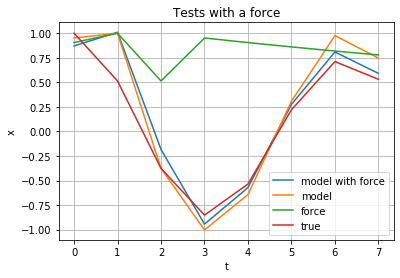

In [13]:
points = list(env.reset().reshape((-1,))[2:].reshape((-1,2)))
points += [env.step([m, delta, big_omega])[0][n_prev+1::n_prev] for _ in range(len(history) - n_prev)]
points = np.array(points).T

assert points[0].shape == points[1].shape
plt.plot(points[0]*points[1] + 0.01, label="model with force")
plt.plot(points[1], label="model")
plt.plot(points[0], label="force")
plt.plot(history, label="true")
plt.grid(True)
plt.legend()
plt.title("Tests with a force")
plt.xlabel("t")
plt.ylabel("x")
plt.show()

# Train

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
agent = AgentCE(env, h_size=32).to(device)

tensor([1.0002e-04, 1.0000e-04, 1.0002e-04]) tensor([1.0000, 0.0100, 1.0000])


In [15]:
best_weight = np.random.randn(agent.get_weights_dim())
agent.set_weights(best_weight)

In [16]:
state = env.observation_space.sample()
state = torch.from_numpy(state).float().to(device)
a = agent.forward(state).numpy()
assert np.isclose(a, [m, delta, big_omega], atol=0.001).all()

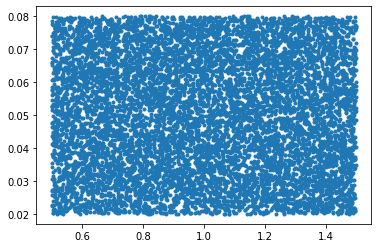

In [17]:
def random_params_rect():
    while True:
        rnd_impact_amplitude = np.random.uniform(0.5, 1.5)
        rnd_damping_ratio = np.random.uniform(0.02, 0.08)
        if not ((0.99 < rnd_impact_amplitude < 1.01)
                and (0.0499 <= rnd_damping_ratio <= 0.051)):
            break
    return rnd_impact_amplitude, rnd_damping_ratio

def plot_random_params(random_params): 
    params_1 = []
    params_2 = []
    for _ in range(10000):
        param_1, param_2 = random_params()
        params_1.append(param_1)
        params_2.append(param_2)
    plt.plot(params_1, params_2, ".")
    plt.show()
    
random_params = random_params_rect
plot_random_params(random_params)  

In [18]:
def create_env(env_model, x_impact, impact_amplitude, damping_ratio):
    impact = lambda t: x_impact(t, impact_amplitude, damping_ratio)
    history = generate_history(t0=t0, step=t_step, n_steps=n_steps, impact=impact)
    env = env_model(history=history, t0=t0, t_step=t_step,n_steps=n_steps, 
                    big_f_0=big_f_0, k=k, n_prev=n_prev, metric=metric)
    env = ImpactWrapper(env, impact, param1=impact_amplitude, param2=damping_ratio)
    env.action_space = gym.spaces.Box(
        np.array([m, delta, big_omega]) - 0.0001,
        np.array([m, delta, big_omega]) + 0.0001,
        dtype=np.float32
    )
    return env

def create_random_env():
    rnd_impact_amplitude, rnd_damping_ratio = random_params()
    return create_env(SimpleModel, x_impact, rnd_impact_amplitude, rnd_damping_ratio)


In [19]:
n_iterations = 10

In [20]:
weights_path = 'weights_test.pth'
scores_path = 'scores_test.pkl'

In [21]:
cem(agent, env, 
    create_random_env, weights_path,
    scores_path, n_iterations, save_every=10)

Episode 10	Average Score: -0.36	Test Score: -0.16
Best Average Score: -0.36	Test Score with Best Average Score: -0.16


In [22]:
def plot_result(envs, models, labels, title_info=""):
    for env, model, label in zip(envs, models, labels):
        s = env.reset()
        d = False
        points = list(s)[-n_prev:]
        while not d:
            state = torch.from_numpy(s).float().to(device)
            a = list(model(state).numpy())
            s, r, d, _ = env.step(a)
            points.append(s[-1])
        plt.plot(points, label=label)
    plt.plot(env.history, label="true")
    plt.title("CE training" + title_info)
    plt.xlabel("t")
    plt.ylabel("x")
    plt.grid(True)
    plt.legend()
    plt.show()

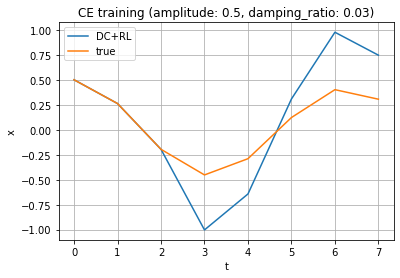

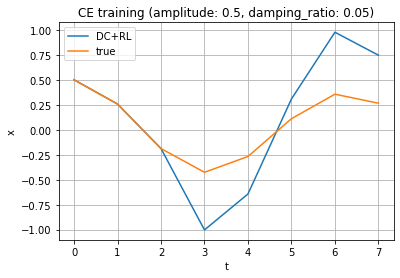

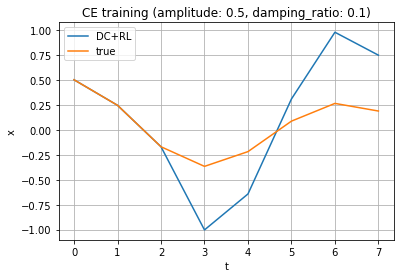

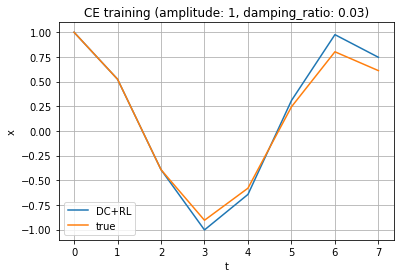

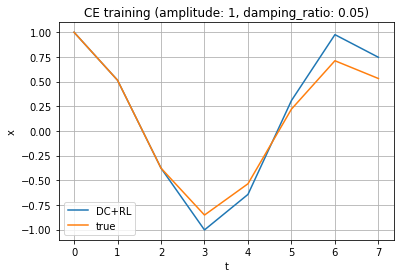

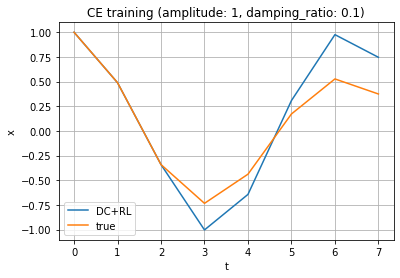

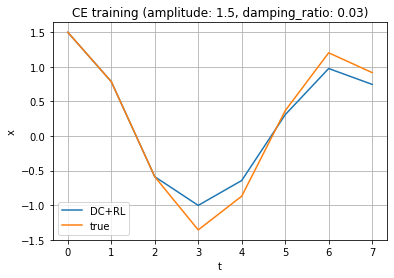

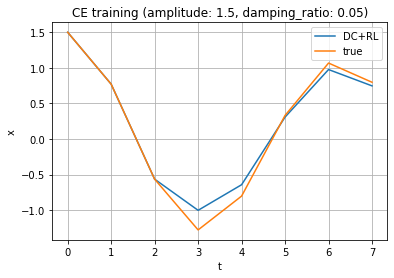

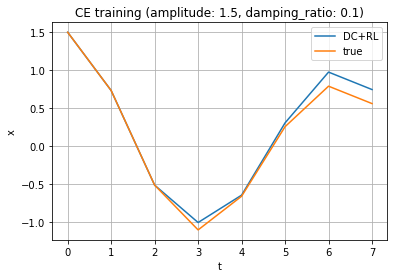

In [23]:
env_models = [SimpleModel]
agents = [agent]
labels = ["DC+RL"]

impact_amplitude_list = [0.5, 1, 1.5]
damping_ratio_list = [0.03, 0.05, 0.1]

for a in impact_amplitude_list:
    for d in damping_ratio_list:
        envs = [
            create_env(env_models[0], x_impact, a, d),
        ]
        info = f" (amplitude: {a}, damping_ratio: {d})"
        plot_result(envs, agents, labels, info)

# Expected behavior =)